# Workflow Debugging

(1188, 20)
Metal device set to: Apple M1 Pro
Epoch 1/100


2022-04-24 08:49:51.174183: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-24 08:49:51.174348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-24 08:49:51.251520: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 9/26 [=========>....................] - ETA: 0s - loss: 1.8400 - accuracy: 0.5833

2022-04-24 08:49:51.401840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 0s 7ms/step - loss: 1.8970 - accuracy: 0.6414
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 1.0127 - accuracy: 0.7184
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 1.2862 - accuracy: 0.7329
Epoch 4/100
26/26 [==============================] - 0s 6ms/step - loss: 0.8449 - accuracy: 0.7521
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 0.7959 - accuracy: 0.7726
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 1.0114 - accuracy: 0.7569
Epoch 7/100
26/26 [==============================] - 0s 6ms/step - loss: 0.7053 - accuracy: 0.7581
Epoch 8/100
26/26 [==============================] - 0s 6ms/step - loss: 0.6489 - accuracy: 0.7702
Epoch 9/100
26/26 [==============================] - 0s 6ms/step - loss: 0.6543 - accuracy: 0.7774
Epoch 10/100
26/26 [==============================] - 0s 6ms/step - loss: 0.6218 - accuracy: 0.7906
Epoch 11/100
26/26 [=

26/26 [==============================] - 0s 6ms/step - loss: 0.2872 - accuracy: 0.8833
Epoch 84/100
26/26 [==============================] - 0s 6ms/step - loss: 0.2594 - accuracy: 0.8857
Epoch 85/100
26/26 [==============================] - 0s 6ms/step - loss: 0.3266 - accuracy: 0.8712
Epoch 86/100
26/26 [==============================] - 0s 6ms/step - loss: 0.2546 - accuracy: 0.8688
Epoch 87/100
26/26 [==============================] - 0s 6ms/step - loss: 0.2888 - accuracy: 0.8700
Epoch 88/100
26/26 [==============================] - 0s 6ms/step - loss: 0.3075 - accuracy: 0.8652
Epoch 89/100
26/26 [==============================] - 0s 6ms/step - loss: 0.2830 - accuracy: 0.8724
Epoch 90/100
26/26 [==============================] - 0s 6ms/step - loss: 0.2922 - accuracy: 0.8508
Epoch 91/100
26/26 [==============================] - 0s 6ms/step - loss: 0.2621 - accuracy: 0.8845
Epoch 92/100
26/26 [==============================] - 0s 6ms/step - loss: 0.2536 - accuracy: 0.8797
Epoch 93/100


2022-04-24 08:50:07.586261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 6ms/step - loss: 0.6097 - accuracy: 0.8431
Accuracy on test data: 0.843137264251709% 
 Error on test data: 0.15686273574829102
len(y_predicted) 357
qftentangled_indep_12.qasm_12  predicted:  2  should be:  1  diff:  999995.090690738
su2random_indep_15.qasm_15  predicted:  1  should be:  0  diff:  0.7013842464576534


2022-04-24 08:50:07.852628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


dj_indep_66.qasm_66  predicted:  0  should be:  8  diff:  0.7306158857276391
portfoliovqe_indep_11.qasm_11  predicted:  0  should be:  2  diff:  6.205368415313425
qft_indep_26.qasm_26  predicted:  0  should be:  1  diff:  0.06400605275763027
qwalk-noancilla_indep_6.qasm_6  predicted:  0  should be:  1  diff:  0.0006741488190975531
su2random_indep_27.qasm_27  predicted:  0  should be:  1  diff:  0.04503384043553993
dj_indep_19.qasm_19  predicted:  2  should be:  8  diff:  999999.1211178547
vqe_indep_18.qasm_18  predicted:  0  should be:  1  diff:  0.05918787769466505
graphstate_indep_12.qasm_12  predicted:  2  should be:  1  diff:  999999.3572569109
groundstate_medium_indep_12.qasm_12  predicted:  0  should be:  1  diff:  0.5252608355070452
dj_indep_78.qasm_78  predicted:  0  should be:  8  diff:  0.6776801641155341
qgan_indep_11.qasm_11  predicted:  0  should be:  2  diff:  2.4470278690936214
qpeexact_indep_27.qasm_27  predicted:  0  should be:  1  diff:  0.33855421682262943
ae_indep_1

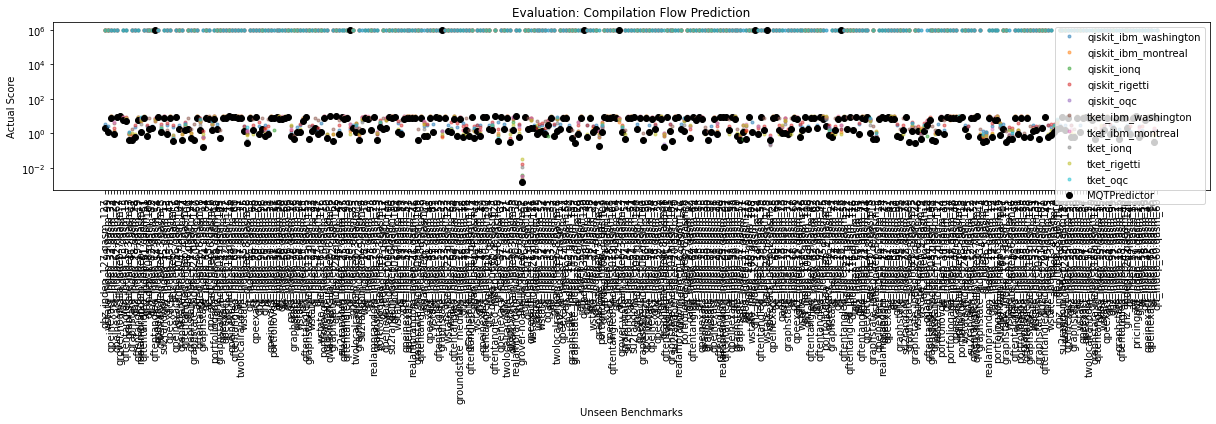

In [1]:
from evaluator.driver import extract_training_data_from_json, train_simple_ml_model
import numpy as np
from sklearn import preprocessing

training_data, names_list, scores_list = extract_training_data_from_json("big_data_new_flow_server.json", True)
#print(names_list)
X, y = zip(*training_data)
X = np.array(X)
y = np.array(y)

non_zero_indices = []
for i in range(len(X[0])):
    if sum(X[:,i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]

scaler = preprocessing.StandardScaler().fit(X)
#X = preprocessing.normalize(X, norm='l2')
#X = scaler.transform(X)

print(X.shape)
train_simple_ml_model(X,y, True, names_list, scores_list)

In [2]:
from sklearn.model_selection import train_test_split
from evaluator.src import utils
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

openqasm_gates_list = utils.get_openqasm_gates()
res = [openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))]
res.append("num_qubits")


features = np.sort(np.array(res))
features = features[non_zero_indices]
print(features)


['ccx' 'cp' 'cry' 'cu' 'cu1' 'cx' 'cz' 'h' 'num_qubits' 'p' 'rx' 'ry' 'rz'
 'rzz' 'swap' 'u' 'u1' 'u2' 'u3' 'x']


0.8931297709923665
Predicted machines:  {0, 1, 2, 3, 4, 5, 7, 8}
Actual machines:  {0, 1, 2, 3, 4, 5, 7, 8}
predicted  1  should be  0
predicted  0  should be  1
predicted  0  should be  1
predicted  8  should be  5
predicted  7  should be  2
predicted  1  should be  0
predicted  1  should be  0
predicted  0  should be  1
predicted  0  should be  1
predicted  3  should be  0
predicted  0  should be  1
predicted  1  should be  0
predicted  1  should be  0
predicted  1  should be  0
predicted  8  should be  1
predicted  0  should be  1
predicted  1  should be  0
predicted  0  should be  8
predicted  0  should be  1
predicted  3  should be  0
predicted  2  should be  7
predicted  0  should be  5
predicted  5  should be  1
predicted  1  should be  5
predicted  0  should be  8
predicted  1  should be  0
predicted  0  should be  1
predicted  0  should be  2
predicted  0  should be  1
predicted  8  should be  5
predicted  1  should be  5
predicted  0  should be  3
predicted  1  should be  0
p

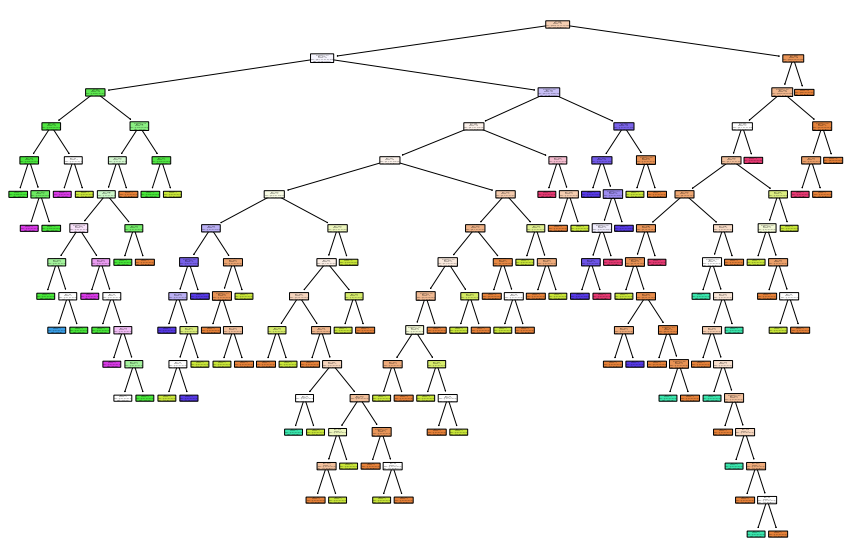

In [3]:
import matplotlib.pyplot as plt
from evaluator.src import utils
from sklearn.tree import plot_tree
from sklearn import tree


clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)

fig = plt.figure(figsize=(15, 10))

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))
available_machines = [utils.get_machines()[i] for i in set(clf.classes_)]
plot_tree(clf, 
          feature_names=features,
          class_names=available_machines,
          filled=True, impurity=True, 
          rounded=True);
plt.savefig("DecisionTreeClassifier.png", dpi=600)

print("Predicted machines: ", set(y_pred))
print("Actual machines: ", set(y_test))
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        print("predicted ", y_pred[i], " should be ", y_test[i])

# Other tested Models

In [4]:
from sklearn.naive_bayes import GaussianNB

clf=GaussianNB()

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.55470737913486


In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier


clf = AdaBoostClassifier(n_estimators=10)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.5928753180661578


1 0.8447837150127226
2 0.8447837150127226
3 0.8727735368956743
4 0.8498727735368957
5 0.8676844783715013
6 0.8702290076335878
7 0.8600508905852418
8 0.8727735368956743
9 0.8651399491094147


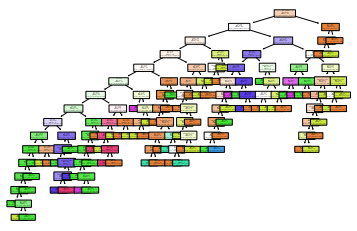

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

#Create a Gaussian Classifier
for i in range(1,10,1):
    clf=RandomForestClassifier(n_estimators=i)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)
    print(i, np.mean(y_pred == y_test))
    plot_tree(clf.estimators_[0], 
          feature_names=features,
          class_names=utils.get_machines(),
          filled=True, impurity=True, 
          rounded=True);

In [7]:
from sklearn.svm import SVC
#Create a Gaussian Classifier

clf=SVC(kernel="linear")

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print(np.mean(y_pred == y_test))

0.8651399491094147


# Debugging

In [8]:
from evaluator import driver
from evaluator.src import utils, pytket_plugin, qiskit_plugin
import pytest
from pytket.extensions.qiskit import qiskit_to_tk
from mqt.bench import get_one_benchmark
from pytket import circuit, OpType

In [9]:
driver.create_gate_lists_from_folder("./qasm_files", 1)

dict_keys(['ae', 'dj', 'excitedstate', 'ghz', 'graphstate', 'groundstate', 'grover-noancilla', 'grover-v-chain', 'hhl', 'portfolioqaoa', 'portfoliovqe', 'pricingcall', 'pricingput', 'qaoa', 'qft', 'qftentangled', 'qgan', 'qpeexact', 'qpeinexact', 'qwalk-noancilla', 'qwalk-v-chain', 'realamprandom', 'routing', 'shor', 'su2random', 'tsp', 'twolocalrandom', 'vqe', 'wstate'])
ae_indep_2.qasm
ae_indep_3.qasm


/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


ae_indep_4.qasm
ae_indep_5.qasm
ae_indep_6.qasm
ae_indep_7.qasm
Calculation/Generation exceeded timeout limit for  <function get_tket_gates at 0x120e4dc10> []
dj_indep_2.qasm
dj_indep_3.qasm
dj_indep_4.qasm
dj_indep_5.qasm
dj_indep_6.qasm
dj_indep_7.qasm
dj_indep_8.qasm
dj_indep_9.qasm
dj_indep_10.qasm
dj_indep_11.qasm
dj_indep_12.qasm
dj_indep_13.qasm
dj_indep_14.qasm
dj_indep_15.qasm
dj_indep_16.qasm
dj_indep_17.qasm
Calculation/Generation exceeded timeout limit for  <function get_tket_gates at 0x120e4dc10> []
excitedstate_small_indep_4.qasm
ghz_indep_2.qasm
ghz_indep_3.qasm
ghz_indep_4.qasm
ghz_indep_5.qasm
ghz_indep_6.qasm
ghz_indep_7.qasm
ghz_indep_8.qasm
ghz_indep_9.qasm
ghz_indep_10.qasm
ghz_indep_11.qasm
ghz_indep_12.qasm
ghz_indep_13.qasm
ghz_indep_14.qasm
ghz_indep_15.qasm
ghz_indep_16.qasm
ghz_indep_17.qasm
ghz_indep_18.qasm
ghz_indep_19.qasm
ghz_indep_20.qasm
ghz_indep_21.qasm
ghz_indep_22.qasm
ghz_indep_23.qasm
ghz_indep_24.qasm
ghz_indep_25.qasm
ghz_indep_26.qasm
ghz_inde